# Using Correlation to Cluster

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import math

In [10]:
online_retail_df = pd.read_json('./online_retail.json')

In [11]:
online_retail_df = online_retail_df.rename(columns={"FuzzedDescription": "Description"})

In [13]:
units_sold_pivoted_df = (
    online_retail_df.pivot(
        index='Date', columns='Description', values='UnitsSold')
    .fillna(0)
)

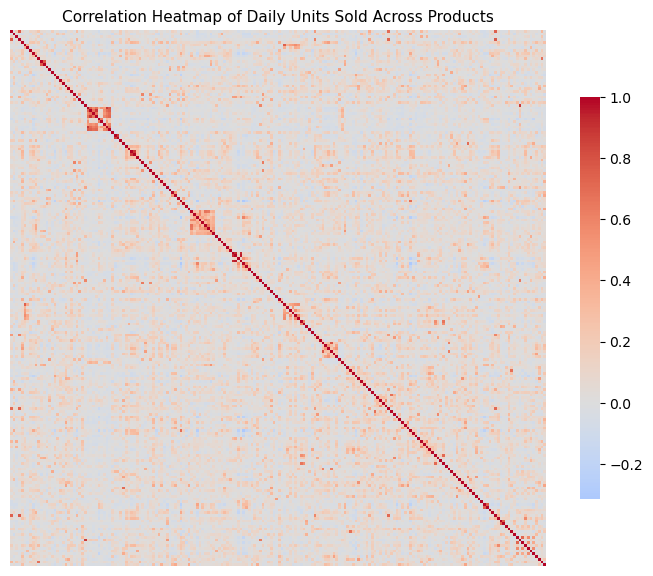

In [18]:
corr_matrix = units_sold_pivoted_df.corr()

plt.figure(figsize=(7, 7))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'shrink': 0.6},
    xticklabels=False,
    yticklabels=False
)
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation Heatmap of Daily Units Sold Across Products', fontsize=11)
plt.tight_layout()
plt.show()

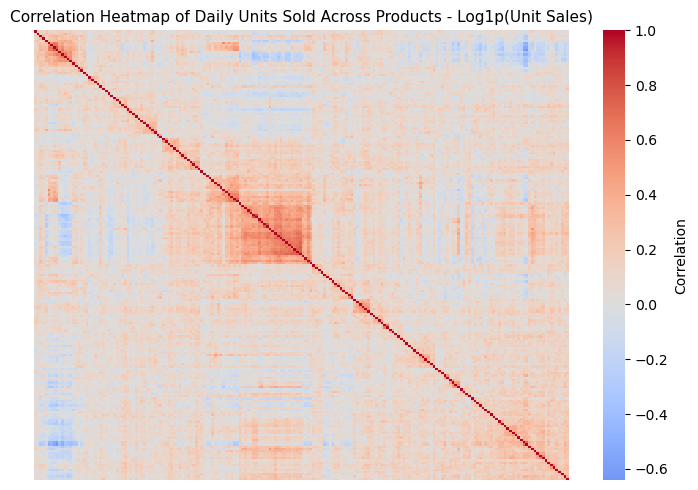

In [25]:
# Log transform to reduce skew
log_product_matrix = np.log1p(units_sold_pivoted_df)

# Correlation matrix
corr_matrix = log_product_matrix.corr()

# Hierarchical clustering to reorder rows/columns
linkage_matrix = linkage(squareform(1 - corr_matrix), method='average')
ordered_idx = leaves_list(linkage_matrix)
ordered_corr = corr_matrix.iloc[ordered_idx, ordered_idx]

# Clean heatmap without dendrogram
plt.figure(figsize=(7,5))
sns.heatmap(
    ordered_corr,
    cmap='coolwarm',
    center=0,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Heatmap of Daily Units Sold Across Products - Log1p(Unit Sales)', fontsize=11)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [54]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.6]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Show top results
high_corr_pairs


,Product A,Product B,Correlation
7634,feltcraft cushion owl,feltcraft cushion rabbit,0.834275
10998,jumbo bag pink with white spots,lunchbag pink retrospot,0.769230
15790,plasters in tin circus parade,plasters in tin spaceboy,0.768990
15791,plasters in tin circus parade,plasters in tin strongman,0.762461
15952,plasters in tin spaceboy,plasters in tin woodland animals,0.759835
...,...,...,...
14357,pack of 6 birdy gift tags,pack of 6 pannetone gift boxes,0.602996
781,6 ribbons rustic charm,baking set spaceboy design,0.602910
2359,baking set spaceboy design,pack of 6 birdy gift tags,0.601660
887,6 ribbons rustic charm,plasters in tin vintage paisley,0.601339


In [55]:
# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

count = 0

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")
    count = count + len(cluster)

print("Number of products that were clustered:", count)

Cluster 1 (2 products): ['feltcraft cushion owl', 'feltcraft cushion rabbit']
Cluster 2 (6 products): ['door mat red spot', 'jumbo bag pink with white spots', 'lunch bag red spotty', 'lunchbag pink retrospot', 'pink 3 piece mini dots cutlery set', 'toy tidy pink retrospot']
Cluster 3 (19 products): ['6 ribbons rustic charm', 'baking set spaceboy design', 'hanging metal star lantern', 'heart of wicker large', 'large popcorn holder', 'magic drawing slate spaceboy', 'pack of 6 birdy gift tags', 'pack of 6 pannetone gift boxes', 'plasters in tin circus parade', 'plasters in tin skulls', 'plasters in tin spaceboy', 'plasters in tin strongman', 'plasters in tin vintage paisley', 'plasters in tin woodland animals', 'regency cakestand 3 tier', 'small popcorn holder', 'sweetheart ceramic trinket box', 'wood black board ant white finish', 'wooden school colouring set']
Cluster 4 (4 products): ['jumbo shopper vintage red paisley', 'lunchbag spaceboy design', 'lunchbag suki design', 'recycling bag

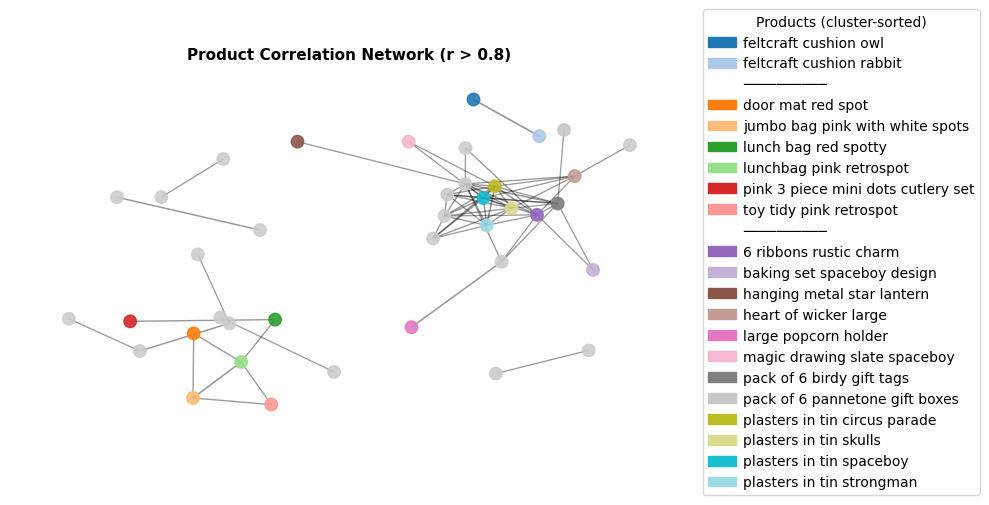

In [56]:
# Extract clusters
clusters = list(nx.connected_components(G))

# Flatten product list (product, cluster_id), sorted by cluster then name
clustered_products = []
for cluster_id, cluster in enumerate(clusters):
    for product in sorted(cluster):
        clustered_products.append((product, cluster_id))

# Limit to top N products
N = 20
top_products = clustered_products[:N]

# Assign distinct colors
tab20 = plt.get_cmap('tab20').colors
product_colors = {
    product: tab20[i % len(tab20)] for i, (product, _) in enumerate(top_products)
}
default_color = (0.8, 0.8, 0.8)

# Compute layout
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw graph
plt.figure(figsize=(10, 5))
node_colors = [product_colors.get(node, default_color) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, alpha=0.9)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    width=[G[u][v]['weight'] * 1.5 for u, v in G.edges()],
    alpha=0.4
)

# Build legend entries, adding separator between cluster transitions
legend_handles = []
last_cluster = None
for product, cluster_id in top_products:
    if last_cluster is not None and cluster_id != last_cluster:
        # Add a separator (a transparent patch with a line as the label)
        legend_handles.append(
            mpatches.Patch(color='none', label='──────────')  # separator line
        )
    legend_handles.append(
        mpatches.Patch(color=product_colors[product], label=product)
    )
    last_cluster = cluster_id

plt.legend(
    handles=legend_handles,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title='Products (cluster-sorted)',
    handletextpad=0.5,
    borderaxespad=1
)

plt.title("Product Correlation Network (r > 0.8)", fontsize=11, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [57]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

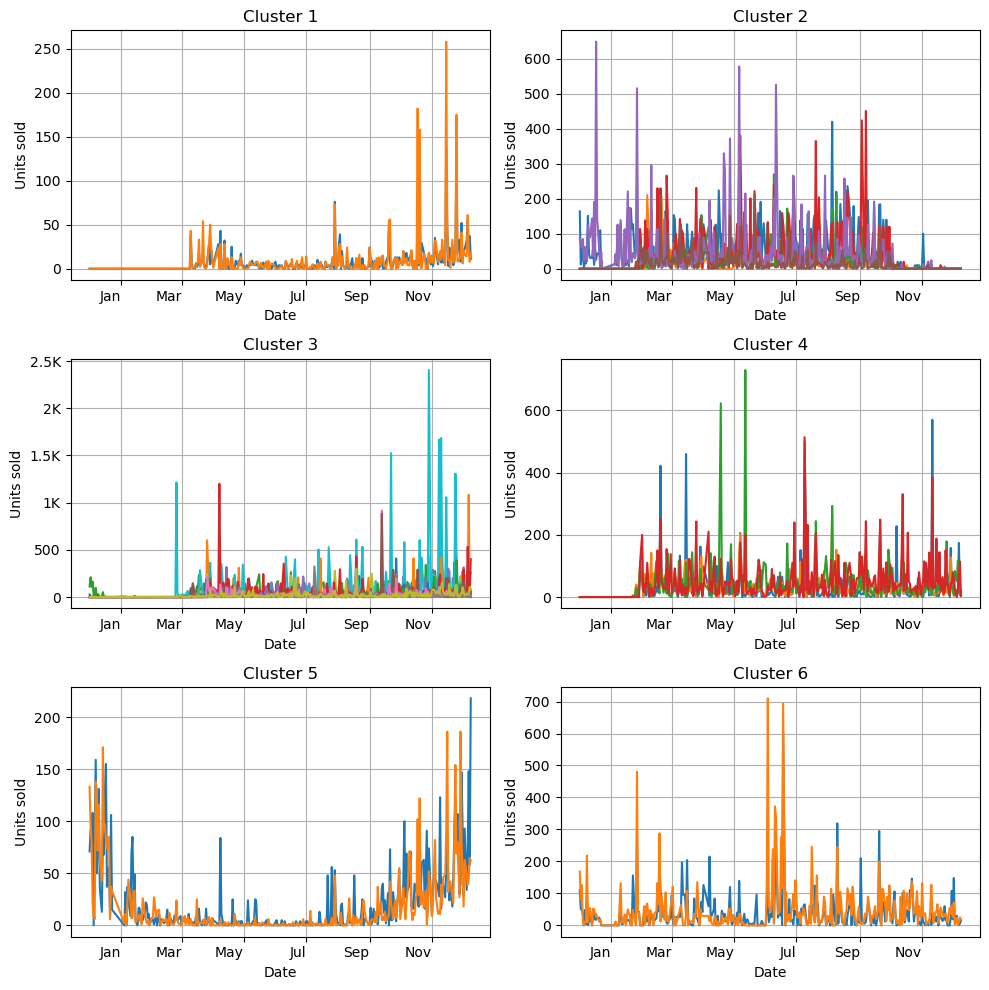

In [58]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for i, (ax, cluster) in enumerate(zip(axs.flatten(), clusters), start=1):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # e.g., 'Jan 2010'
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [59]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.5]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")

Cluster 1 (27 products): ['6 ribbons rustic charm', 'baking set spaceboy design', 'doorstop retrospot heart', 'feltcraft cushion owl', 'feltcraft cushion rabbit', 'hanging metal star lantern', 'heart of wicker large', 'large popcorn holder', 'magic drawing slate spaceboy', 'memo board cottage design', 'memo board retrospot design', 'natural slate rectangle chalkboard', 'pack of 6 birdy gift tags', 'pack of 6 pannetone gift boxes', 'plasters in tin circus parade', 'plasters in tin skulls', 'plasters in tin spaceboy', 'plasters in tin strongman', 'plasters in tin vintage paisley', 'plasters in tin woodland animals', 'regency cakestand 3 tier', 'retro spot tea set ceramic 11 pc', 'small popcorn holder', 'sweetheart ceramic trinket box', 'white wood garden plant ladder', 'wood black board ant white finish', 'wooden school colouring set']
Cluster 2 (15 products): ['blue spotty cup', 'charlotte bag pinkwhite spots', 'door mat red spot', 'jumbo bag pink with white spots', 'jumbo bag spaceboy 